### Loading and cleaning data

In [27]:
# Required imports
import pandas as pd
import math

pd.set_option('display.max_columns',30)

# Load data
dataset_df1 = pd.read_csv(r"./premonsoon/ground_water_quality_2018_pre.csv")
dataset_df2 = pd.read_csv(r"./premonsoon/ground_water_quality_2019_pre.csv")
dataset_df3 = pd.read_csv(r"./premonsoon/ground_water_quality_2020_pre.csv")
dataset_df4 = pd.read_csv(r"./premonsoon/ground_water_quality_2021_pre.csv")
dataset_df5 = pd.read_csv(r"./premonsoon/ground_water_quality_2022_pre.csv")
dataset_df6 = pd.read_csv(r"./postmonsoon/ground_water_quality_2018_post.csv")
dataset_df7 = pd.read_csv(r"./postmonsoon/ground_water_quality_2019_post.csv")
dataset_df8 = pd.read_csv(r"./postmonsoon/ground_water_quality_2020_post.csv")
dataset_df9 = pd.read_csv(r"./postmonsoon/ground_water_quality_2021_post.csv")
dataset_df = pd.concat([dataset_df1,dataset_df2,dataset_df3,dataset_df4,dataset_df5,dataset_df6,dataset_df7,dataset_df8,dataset_df9],join='outer',ignore_index=True)
dataset_df.drop(columns=['RL_GIS','sno','village','mandal','district','gwl'],inplace=True)
dataset_df['season']=dataset_df['season'].astype(str).apply(lambda x: 0 if 'pre' in x.lower() else 1)
# End load data

# Changing fields to numeric equivalents.
dataset_df['pH'] = pd.to_numeric(dataset_df['pH'], errors='coerce')
# Now convert to float
dataset_df['pH'] = dataset_df['pH'].astype(float)
dataset_df['RSC  meq  / L'] = pd.to_numeric(dataset_df['RSC  meq  / L'], errors='coerce')
# Now convert to float
dataset_df['RSC  meq  / L'] = dataset_df['RSC  meq  / L'].astype(float)
# End changing fields

# Remove Null values
for index, row in dataset_df.iterrows():
    if 'NA' in row.values:
        dataset_df.drop(index, inplace=True)
    elif(row['Classification']=='OG')or(row['Classification']=='O.G')or(row['Classification']=='BELOW THE GRAPH')or(row['Classification']=='OUT OF SAR GRAPH')or(row['Classification']=='BG'):
        dataset_df.drop(index, inplace=True)
dataset_df.reset_index(drop=True, inplace=True)

null_threshold = len(dataset_df) * 0.25
for column in dataset_df.columns:
    null_count = dataset_df[column].isnull().sum()
    if null_count > null_threshold:
        dataset_df.drop(column, axis=1, inplace=True)
    elif null_count > 0:
        dataset_df.dropna(subset=[column], inplace=True)
dataset_df.reset_index(drop=True, inplace=True)

data = dataset_df
# End remove null

### kNN (k Nearest Neighbours) Algorithm

The k nearest neighbours algorithm is a non-parametric supervised learning algorithm.  
Its **training** phase only consists of storing the data.  
Its **classification** phase involves of calculating the k nearest neighbours (according to some "distance" metric) to the new data for which classification is sought and then finding representative label of those k neighbours and assigning the new data this label. The k mentioned here is given as a parameter and is not learnt, though there are thumb rules (such as sqrt(n), n = # datapoints) and some procedures which can make better choices for k.  

<img src="images/kNN_Explanation.png" width="800" />

#### Notes regarding implementation:  
There are other kinds of representation of data which help in finding nearest neighbour more quickly than the naive method, which we do not consider here for implementation.  
We implement the naive method, which implies that distance of new point from all points is first calculated,   
and we then determine the k neighbours, closest to this point, and then simply find the label which occurs maximum number of times  
(we have some other rules such as requiring a majority vote, which is defined to be a situation where the majority has to exceed  
 all others by the proportion of number of classes).   
The k chosen in our implementation is sqrt(n), where n is the number of datapoints. Also the metric used is the usual Euclidean Norm/ L2 Norm.    
Also, due to non-parallelized implementation, the function is extremely slow and might take around 5-15 minutes to give the results.  
The accuracy obtained, however is similar/comparable with the standard library packages implementation. (See below)

<img src="images/kNN_Algorithm_Pseudocode.png" width="800" />

### kNN Implementation without `sklearn`

In [28]:
# Euclidean metric/L2 norm metric
def calculate_distance(row : pd.Series,trow : pd.Series) -> float:
    dist = 0
    for index,value in row.items():
        if index != 'Classification' and index != 'Classification.1':
            dist += (value-trow[index])**2
    return math.sqrt(dist)

# Return the label with maximum count only (No '> 1/unique_label_count' done).
def getMajorityLabel(neighbourList: list) -> str:
    freqList = []
    for item in neighbourList:
        for tup in freqList:
            if tup[0] == item[1]:
                tup[1] = tup[1] + 1
                break
        else:
            freqList.append([item[1],1])
    majority_label = ''
    max_freq = 0
    for item in freqList:
        if max_freq < item[1]:
            majority_label = item[0]
            max_freq = item[1]
    return majority_label

# Naive kNN
# For classification, measure distance of given (new) data to all other test data 
# and sort the distances and take the least k from these with their labels and
# find the majority label among these and assign that label to the given data.
def KNN_classifier(dataframe:pd.DataFrame,test_data:pd.DataFrame,K:int) -> None:
    req_data = dataframe 
    req_test_data = test_data
    totalTests = req_test_data.shape[0]
    totalCorrectClassifications = 0
    for tindex,trow in req_test_data.iterrows():
        nearest_neighbours = []
        for index,row in req_data.iterrows():
            nearest_neighbours.append((calculate_distance(row,trow),row['Classification']))
        nearest_neighbours.sort()
        nearest_neighbours = nearest_neighbours[0:K-1]
        if trow['Classification'] == getMajorityLabel(nearest_neighbours):
            totalCorrectClassifications = totalCorrectClassifications+1
    print(totalCorrectClassifications/totalTests *100)

# Split data into 80-20 as train and test data sets
train = data.sample(frac=0.8,random_state=8)
test = data.drop(train.index)

# Parameter k : first choice
K =  math.ceil(math.sqrt(train.shape[0]))

train = train.reset_index(drop=True)
test = test.reset_index(drop=True)

### Running the kNN on test data

In [29]:
# Actual Classification phase.
KNN_classifier(train,test,K=K)

91.39213602550478


### Using `sklearn` kNN to compare performance with above implementation.

In [30]:
# Required imports
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import LabelEncoder

# sklearn requires numerical labels for output also, so use label encoding for categories
label_encoder = LabelEncoder()
data['encoded_Classification'] = label_encoder.fit_transform(data['Classification'])

# Same split
train = data.sample(frac=0.8,random_state=8)
test = data.drop(train.index)

# sklearn requires separate input data and output labels (encoded)
trainX = train.drop(['Classification','encoded_Classification','Classification.1'],axis=1)
trainY = train['encoded_Classification']

testX = test.drop(['Classification','encoded_Classification','Classification.1'],axis=1)
testY = test['encoded_Classification']

# Parameter k : first choice
K =  math.ceil(math.sqrt(train.shape[0]))
knn_classifier = KNeighborsClassifier(n_neighbors=K)
knn_classifier.fit(trainX,trainY)

# Inbuilt function to calculate accuracy on test data set
accuracy = knn_classifier.score(testX, testY)
print(100*accuracy)

91.49840595111584


c:\Users\p0803\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


### Using reduced dataset obtained from PCA

In [31]:
reduced_dataset_df = pd.read_csv(r"Reduced_features_dataset.csv")

# Remove Null values
for index, row in reduced_dataset_df.iterrows():
    if 'NA' in row.values:
        reduced_dataset_df.drop(index, inplace=True)
    elif(row['Classification']=='OG')or(row['Classification']=='O.G')or(row['Classification']=='BELOW THE GRAPH')or(row['Classification']=='OUT OF SAR GRAPH')or(row['Classification']=='BG'):
        reduced_dataset_df.drop(index, inplace=True)
reduced_dataset_df.reset_index(drop=True, inplace=True)


null_threshold = len(reduced_dataset_df) * 0.25
for column in reduced_dataset_df.columns:
    null_count = reduced_dataset_df[column].isnull().sum()
    if null_count > null_threshold:
        reduced_dataset_df.drop(column, axis=1, inplace=True)
    elif null_count > 0:
        reduced_dataset_df.dropna(subset=[column], inplace=True)
reduced_dataset_df.reset_index(drop=True, inplace=True)

data = reduced_dataset_df

reduced_train = data.sample(frac=0.8,random_state=8)
reduced_test = data.drop(reduced_train.index)

new_K = math.ceil(math.sqrt(reduced_train.shape[0]))

reduced_train = reduced_train.reset_index(drop=True)
reduced_test = reduced_test.reset_index(drop=True)

#### Running the implemented kNN algorithm on the reduced dataset

In [32]:
KNN_classifier(reduced_train,reduced_test,new_K)

85.01529051987767


#### Running the `sklearn` library on reduced dataset

In [33]:
# sklearn requires numerical labels for output also, so use label encoding for categories
new_label_encoder = LabelEncoder()
data['encoded_Classification'] = new_label_encoder.fit_transform(data['Classification'])

# Same split
reduced_train = data.sample(frac=0.8,random_state=8)
reduced_test = data.drop(reduced_train.index)

# sklearn requires separate input data and output labels (encoded)
reduced_trainX = reduced_train.drop(['Classification','encoded_Classification'],axis=1)
reduced_trainY = reduced_train['encoded_Classification']

reduced_testX = reduced_test.drop(['Classification','encoded_Classification'],axis=1)
reduced_testY = reduced_test['encoded_Classification']

# Parameter k : first choice
new_K =  math.ceil(math.sqrt(reduced_train.shape[0]))
knn_classifier = KNeighborsClassifier(n_neighbors=new_K)
knn_classifier.fit(reduced_trainX,reduced_trainY)

# Inbuilt function to calculate accuracy on test data set
new_accuracy = knn_classifier.score(reduced_testX, reduced_testY)
print(100*new_accuracy)

84.91335372069318


c:\Users\p0803\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


### Running for different k Values and plotting the result for both the Original dataset and Reduced dataset.

In [34]:
K = [3,5,math.ceil(math.log(train.shape[0])),math.ceil((train.shape[0])**(1/3)),math.ceil(math.sqrt(train.shape[0])),math.ceil((train.shape[0])/math.log(train.shape[0])),train.shape[0]]
accuracy_impl_on_original_dataset = []

def modified_KNN_classifier(dataframe:pd.DataFrame,test_data:pd.DataFrame,K:int) -> None:
    req_data = dataframe 
    req_test_data = test_data
    totalTests = req_test_data.shape[0]
    totalCorrectClassifications = 0
    for tindex,trow in req_test_data.iterrows():
        nearest_neighbours = []
        for index,row in req_data.iterrows():
            nearest_neighbours.append((calculate_distance(row,trow),row['Classification']))
        nearest_neighbours.sort()
        nearest_neighbours = nearest_neighbours[0:K-1]
        if trow['Classification'] == getMajorityLabel(nearest_neighbours):
            totalCorrectClassifications = totalCorrectClassifications+1
    accuracy_impl_on_original_dataset.append(totalCorrectClassifications/totalTests *100)
    print('K = ',K,', accuracy = ',totalCorrectClassifications/totalTests *100)

### Running the (modified) implementation on original dataset with different k

In [35]:
for k in K:
    modified_KNN_classifier(train,test,k)

K =  3 , accuracy =  92.0297555791711
K =  5 , accuracy =  92.13602550478215
K =  9 , accuracy =  92.0297555791711
K =  16 , accuracy =  92.0297555791711
K =  62 , accuracy =  91.39213602550478
K =  458 , accuracy =  87.77895855472902
K =  3764 , accuracy =  62.911795961742826


### Running `sklearn` on original dataset with different k

In [45]:
accuracy_sklearn_on_original_dataset = []
for k in K:
    knn_classifier = KNeighborsClassifier(n_neighbors=k)
    knn_classifier.fit(trainX,trainY)
    # Inbuilt function to calculate accuracy on test data set
    new_accuracy = knn_classifier.score(testX,testY)
    print('k = ',k,', accuracy = ',new_accuracy*100)
    accuracy_sklearn_on_original_dataset.append(new_accuracy*100)

c:\Users\p0803\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
c:\Users\p0803\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdim

k =  3 , accuracy =  91.39213602550478
k =  5 , accuracy =  91.81721572794899


c:\Users\p0803\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
c:\Users\p0803\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdim

k =  9 , accuracy =  91.49840595111584
k =  16 , accuracy =  91.71094580233795


c:\Users\p0803\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
c:\Users\p0803\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdim

k =  62 , accuracy =  91.49840595111584
k =  458 , accuracy =  87.77895855472902
k =  3764 , accuracy =  62.911795961742826


c:\Users\p0803\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


### Running the (modified) implementation on reduced dataset with different k

In [37]:
accuracy_impl_on_reduced_dataset = []

def modified_reduced_KNN_classifier(dataframe:pd.DataFrame,test_data:pd.DataFrame,K:int) -> None:
    req_data = dataframe 
    req_test_data = test_data
    totalTests = req_test_data.shape[0]
    totalCorrectClassifications = 0
    for tindex,trow in req_test_data.iterrows():
        nearest_neighbours = []
        for index,row in req_data.iterrows():
            nearest_neighbours.append((calculate_distance(row,trow),row['Classification']))
        nearest_neighbours.sort()
        nearest_neighbours = nearest_neighbours[0:K-1]
        if trow['Classification'] == getMajorityLabel(nearest_neighbours):
            totalCorrectClassifications = totalCorrectClassifications+1
    accuracy_impl_on_reduced_dataset.append(totalCorrectClassifications/totalTests *100)
    print('K = ',K,', accuracy = ',totalCorrectClassifications/totalTests *100)

for k in K:
    modified_reduced_KNN_classifier(reduced_train,reduced_test,k)

K =  3 , accuracy =  96.02446483180428
K =  5 , accuracy =  95.41284403669725
K =  9 , accuracy =  95.20897043832824
K =  16 , accuracy =  93.88379204892966
K =  62 , accuracy =  91.23343527013252
K =  458 , accuracy =  82.36493374108052
K =  3764 , accuracy =  61.87563710499491


### Running `sklearn` on reduced dataset with different k

In [38]:
accuracy_sklearn_on_reduced_dataset = []

for k in K:
    knn_classifier = KNeighborsClassifier(n_neighbors=k)
    knn_classifier.fit(reduced_trainX,reduced_trainY)
    # Inbuilt function to calculate accuracy on test data set
    new_accuracy = knn_classifier.score(reduced_testX, reduced_testY)
    print('k = ',k,', accuracy = ',new_accuracy*100)
    accuracy_sklearn_on_reduced_dataset.append(new_accuracy*100)

c:\Users\p0803\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
c:\Users\p0803\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdim

k =  3 , accuracy =  86.74821610601427
k =  5 , accuracy =  86.95208970438328
k =  9 , accuracy =  87.05402650356778
k =  16 , accuracy =  86.64627930682977


c:\Users\p0803\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
c:\Users\p0803\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdim

k =  62 , accuracy =  85.01529051987767
k =  458 , accuracy =  75.53516819571865
k =  3764 , accuracy =  61.87563710499491


c:\Users\p0803\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


### Plotting the accuracies obtained.

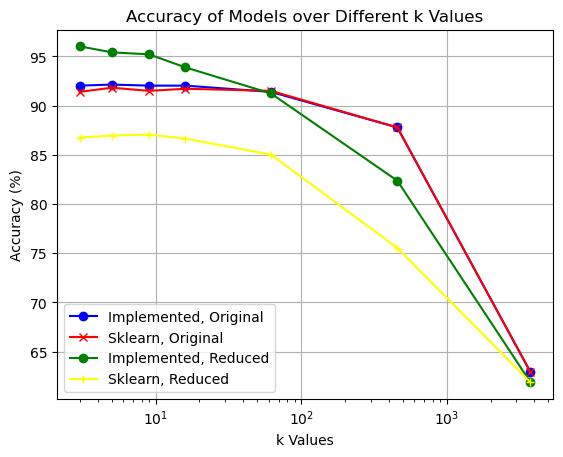

In [46]:
import matplotlib.pyplot as plt

# Plotting the accuracies for both models
plt.plot(K, accuracy_impl_on_original_dataset, marker='o', color='blue', label='Implemented, Original')
plt.plot(K, accuracy_sklearn_on_original_dataset, marker='x', color='red', label='Sklearn, Original')
plt.plot(K, accuracy_impl_on_reduced_dataset, marker='o', color='green', label='Implemented, Reduced')
plt.plot(K, accuracy_sklearn_on_reduced_dataset, marker='+', color='yellow', label='Sklearn, Reduced')

# Customizing the x-axis labels
x_labels = ['3', '5', 'log n', 'cube root n', 'sqrt n', 'n / log n', 'n']
plt.xticks(K, x_labels)

plt.xscale('log')

# Adding labels and title
plt.xlabel('k Values')
plt.ylabel('Accuracy (%)')
plt.title('Accuracy of Models over Different k Values')

# Adding legend
plt.legend()

# Displaying the plot
plt.grid(True)
plt.show()